## We no want Gwen to Die

Gwen Stacy is Spiderman's formerly alive ex-girlfriend. That's sad. He didn't even get to break up with her. She died. In his arms. At his hands.

The scenario begins as such: Spiderman is fighting the green goblin (not the hobgoblin, he hasn't made any movie appearances yet), in a giant clock tower. Gwen Stacy (SpyderBoi's, at the time, living girlfriend) was dangling from his web in the clcok. Well as expected, Spiderbuddy makes a wrong step, the web breaks, the clock breaks, and Gwen is accelerating towards the ground with giant metal gears and clocks. Spiderman dives, shoots his web at her, and then he grabs onto a metal bar, stopping himself, but leaving her survival solely on the physics of her body and the web. In case it wasn't clear, she died. 

In the movie, the web attached to her abdomen as she was falling, and she died because her head hit the floor with too great of an acceleration. In other words, SpideyBoi was just a wee bit too slow to be the be the cool guy that beats the villain and gets the girl. Realistically, we wanted to model the forces and motion of this fall, to determine how she could have survived if she hadn't hit the ground. This would require the force of tension in the web to be less than what's necessary to break a human spine. 

Our goal is to determine the optimal catch time for Gwen Stacy's mortal vessel along with optimal elasticity for spiderman's webs. 

Varying change in time (time from max v to 0 m/s) through swept values or ODE solver (in which would vary the force exerted on her body). This would be the amount of time it took for Gwen Stacy's mortal vessel to stop falling once she was caught by the web that could've broken her spine if she had not busted her head on the ground. 

If we sweep change in time values for velocity, we would have control over the amount of time it would take for her to stop falling. Using ODE solver would allow for us to stop the simulation once a lethal amount of force is exerted upon her human vessel (thus causing unaliving). 


### Question?

What would be the optimal time to catch Gwen Stacy as she was falling from the clock tower so that she could survive the forces on her body?

### Model

Below begins the configuration and the continuation of our model.

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *


In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
N = UNITS.newtons

<Unit('newton')>

In this model, we are tracking position and velocity. So, we are going to prepare for this by writing functions that will graph these variables.

In [3]:
def plot_position(results):
    plot(results.height) #plots height
    decorate(xlabel='Time (s)', #labels x-axis as Time(s)
             ylabel='Position (m)') #labels y-axis Position (m)
    

In [4]:
def plot_velocity(results):
    plot(results.velocity, color='C1', label='v') #plots velocity
        
    decorate(xlabel='Time (s)', #labels x-axis as Time(s)
             ylabel='Velocity (m/s)') #labels y-axis Velocity (m/s)

As you can see in the Params function below, there are certain assumptions we make in this model, the most primary of which is that upon a broken spine we assume Gwen will die. We also assume that spider-man stays at a constant height, and doesn't dive after Gwen like in the movie. Many other values, such as the spring constant of spider-man's webbing and gwen stacey's weight were found from different marvel databases. And finally values such as height of the building and density, etc., were chosen based on estimations based on the movie or physics sites. 

In [5]:
params = Params( 
    g = 9.81* m / s**2, #gravity
    forceOfDeath = 3000 * N, #amount of force found to break a human spine
    k = 7.74e4*N/m, #spring constant
    terminal_velocity = 53 * m /s, #terminal velocity of a human being
    height_building = 100 * m, #height of the building, a.k.a. initial height
    L = 50 * m, #Length of webbing when spiderman goes for the catch, we assume that this length is perfect due to Spider Senses
    mass = 59*kg,
    rho = 1.2 * kg/m**2, #density
    area = 1 * m**2 
    )

,values
g,9.81 meter / second ** 2
forceOfDeath,3000 newton
k,77400.0 newton / meter
terminal_velocity,53.0 meter / second
height_building,100 meter
L,50 meter
mass,59 kilogram
rho,1.2 kilogram / meter ** 2
area,1 meter ** 2


In [6]:
def make_system(params):
    unpack(params)
    init = State(height = height_building, velocity = 0*m/s)
    
    C_d = 2 * mass * g / (rho * area * terminal_velocity**2)
    t_end = 15 * s
    
    return System(params, C_d = C_d, 
                  init = init, t_end = t_end)

In [7]:
system = make_system(params)

,values
g,9.81 meter / second ** 2
forceOfDeath,3000 newton
k,77400.0 newton / meter
terminal_velocity,53.0 meter / second
height_building,100 meter
L,50 meter
mass,59 kilogram
rho,1.2 kilogram / meter ** 2
area,1 meter ** 2
C_d,0.3434140263438947 1 / meter


Below is the function we used to calculate the force at every given height

In [8]:
def force_spring(system, height):
    
    unpack(system)   
    
    delta_height = height_building - height
    if delta_height < L:
        return 0 * N
    stretch_length = delta_height - L
    spr_force = k * stretch_length
    #print(spr_force)
    return spr_force


Below is the function we use to calculate the Drag Force at given velocities

In [9]:
def force_drag(system, velocity):
    
    unpack(system)
    
    f_drag = -np.sign(velocity) * rho * velocity**2 * C_d * area / 2
    return f_drag

Below is slope function that we use for our ode solver, in which we find the velocity and acceleration at each time step, based on the forces at the velocities and heights based on time.

In [10]:
def slope_func(state, time, system):
    
    y, velocity = state
    
    unpack(system)
    
    a_spring = force_spring(system, y) / mass #Finds acceleration due to the Spring Force / Mass
    a_drag = force_drag(system, velocity) / mass #Finds acceleration due to the Drag Force / Mass
    
    acceleration = -g + a_spring + a_drag #Calculates the net acceration based on gravity, spring acceleration and drag acceleration
    
    return velocity, acceleration
    

Below is the function we use within our time sweep function, in this slope function we only return acceleration, due to the different structure of the function which will be described below.

In [11]:
def slope_func2(height, velocity, time, system):
    
    unpack(system)
    
    a_spring = force_spring(system, height) / mass #Finds acceleration due to the Spring Force / Mass
    a_drag = force_drag(system, velocity) / mass #Finds acceleration due to the Drag Force / Mass
    
    acceleration = -g + a_spring + a_drag #Calculates the net acceration based on gravity, spring acceleration and drag acceleration
    
    velocity = acceleration*time + velocity #finds velocity based on acceleration and time
    
    return acceleration

This event function returns when the height is 0, so that way Gwen doesn't go crashing through a ground that doesn't exist. 

In [12]:
def event_func(state, time, system):
    y, velocity = state
    
    return y
    

Finally we run through the ODE solver

In [13]:
results, details = run_ode_solver(system, slope_func, max_step = .1 * s, events = event_func)

### Results

And below you will see the results which show Gwen Stacy's y position over time, her velocity as v = dy/dt, and her acceleration as a = dv/dt = dy^2/dt.

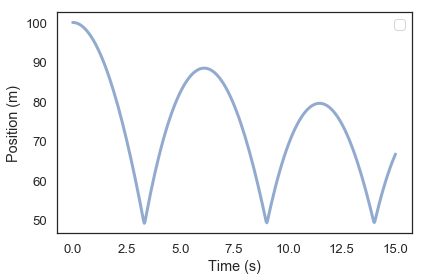

In [14]:
plot_position(results)

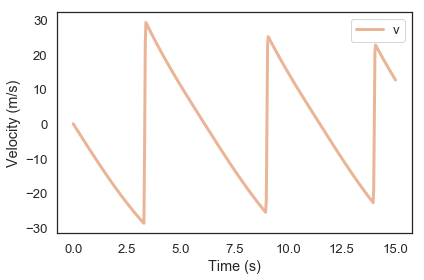

In [15]:
plot_velocity(results)

Here you see we manipulate the velocity data, to find the acceleration at each timestep. Then we record the maximum acceleration throughout the run, to find the maximum force.

<Quantity(850.4840992539125, 'meter / second ** 2')>

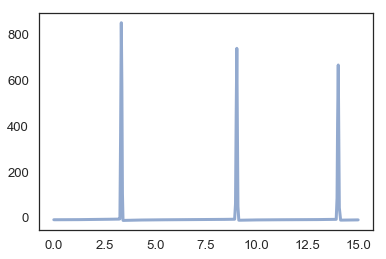

In [16]:
accel3 = gradient(results.velocity)
plot(accel3)
max_acceleration = max(accel3) * m/s**2

The maximum force is important, since it's the maximum value of acceleration it allows us to determine Gwen's Surival based on whether or not the force is greater than or equal to the force required to break a human spine. 

In the movie, the web attached to her abdomen as she was falling, and she died because her head hit the floor with too great of an acceleration. Realistically, we wanted to model the forces and motion of this fall, to determine how she could have survived if she hadn't hit the ground. This would require the force of tension in the web to be less than what's necessary to break a human spine. 

In [17]:
max_force = max_acceleration * system.mass

<Quantity(50178.561855980835, 'kilogram * meter / second ** 2')>

Now we begin the portion of our code which actually runs the simulation. The code above shows the steps the following code will take for each run. 
Directly below is the State function we use to keep track of important variables.

In [18]:
track = State(force = 0)

,values
force,0


Below is the function we use to determine the length of web that spiderman shoots, based on the time of the catch.

In [19]:
def web_length_solver(t, accel, speed, L):
    if t == 0:
        speed = 0*m/s
        L = 0*m
    else:
        print(accel)
        speed = t*accel*s
        print("We made it!")
        L = L + (speed*s)
    
    
    return L, speed
  

This is the main function. It sweeps the time at which spiderman makes the catch and calculates the different effects of this sweep. This function creates a simulation for each event with different catch times. 


This would be an extension to our results, but we are having trouble in the execution of this block of code. But it will hopefully be remediated very soon. Then we know whether Arachnid_Derived_Powers_Boi could have made a difference. It doesn't matter if he could have made a difference, because she died. 

In [22]:
def sweep_time(state, params, make_sys, slope_func, event_func):
    unpack(params)
    frame = TimeFrame(columns= track.index)#establishes the number of cells per
                                           #cell type as a Time Frame
    t_0 = 0
    t_end = 15
    frame.row[0] = track.force #puts the initial cell numbers into the Time Frame
    
    speed = 0 * m / s #initial speed
    accel = 9.81*m /s**2 #initial acceleration
    height = 1 * m #initial height fallen
    
    thisIsTheFirstTimeBecauseItIs = True #Keeps track of how far in the linrange the for loop is 

    for t in linrange(t_0, t_end, endpoint=True ): #counts how many steps we need to run
                                       #through and how many we have ran through
        if thisIsTheFirstTimeBecauseItIs == True: #If this is the first time that the code is run through the for loop then these params exist
            params = Params( 
          g = 9.81* m / s**2,
          forceOfDeath = 3000 * N,
          k = 7.74e4*N/m,
          terminal_velocity = 53 * m /s,
          height_building = 100 * m,
          L = 1 * m,
          mass = 59*kg,
          rho = 1.2 * kg/m**2,
          area = 1 * m**2
          )
        else:                                     #Otherwise these params exist, because these respond to the following code, and react to event changes
             params = Params( 
          g = 9.81* m / s**2,
          forceOfDeath = 3000 * N,
          k = 7.74e4*N/m,
          terminal_velocity = 53 * m /s,
          height_building = 100 * m,
          L = WebLength,
          mass = 59*kg,
          rho = 1.2 * kg/m**2,
          area = 1 * m**2
          )
        system = make_system(params)    
        
        WebLength, speed = web_length_solver(t, accel, speed, L) #Calculates WebLength
        
    
        
        accel = slope_func2(L, speed, t*s, system) #Calculates acceleration

        results, details = run_ode_solver(system, slope_func, max_step = .1 * s,
                                          events = event_func) #records the 
                                                         #results from each step
        velocity = max(results.velocity) #max velocity from that event
        acceleration = gradient(results.velocity) #accelerations from last event
        max_acceleration = max(acceleration) * m/s**2 #max accel
        max_force = (max_acceleration * system.mass).to(UNITS.newton) #max force

        #print(f't: {t}, dt: {dt}, {max_force}')
        frame.row[t] = max_force
        
        thisIsTheFirstTimeBecauseItIs = False #Marks that one run has been made
        
      
    #returns the final Time Frame, which contains the number of cells for each step through
    return frame

In [23]:
results = sweep_time(track, params, system, slope_func, event_func)
plot(results)

128552.90186440678 meter / second ** 2
We made it!


TypeError: object of type 'numpy.float64' has no len()

### Interpretation

We were divided on the answer to this modeling question. Naturally, I, the Jerry Goss have no faith in SpiderTeen's ability to save a girl who didn't have verifiable feelings for him (him being a fairly poor rendition of Spiderman with weird facial expressions). I think Gwen Stacy would have died in all of the arguably realistic scenarios. But who knows, maybe he could have saved her to a point in which she would be in a vegetative state. This is something we cannot accurately quantify, so we assume she lives if she doesn't reach death force. 

Once our sweep_time is functional, we'll be able to have an answer to this question. But it's not ready yet. 

Iteration played a huge role in the process as we had to continually iterate different models in order to get what we wanted out of this. We struggled a lot with web attributes and scratched our equations and code a couple of times. We began to see how the bungee jump model could offer us insight into how to approach this problem and it definitely did, especially in regard to equations. We believe we could simplify this significantly by keeping web length constant, so that the elastic quality of the web remains constant, and we could only vary spiderman's height. This would give us control over her max velocity, which contributes to the resulting forc on her body, without the excess content regarding varying natural and stretched lengths of the web for various lengths. 